C:\Users\saucourt\AppData\Local\Temp\ipykernel_29012\2065561033.py:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  trajectories = torch.tensor(trajectories)  # shape (steps, d)


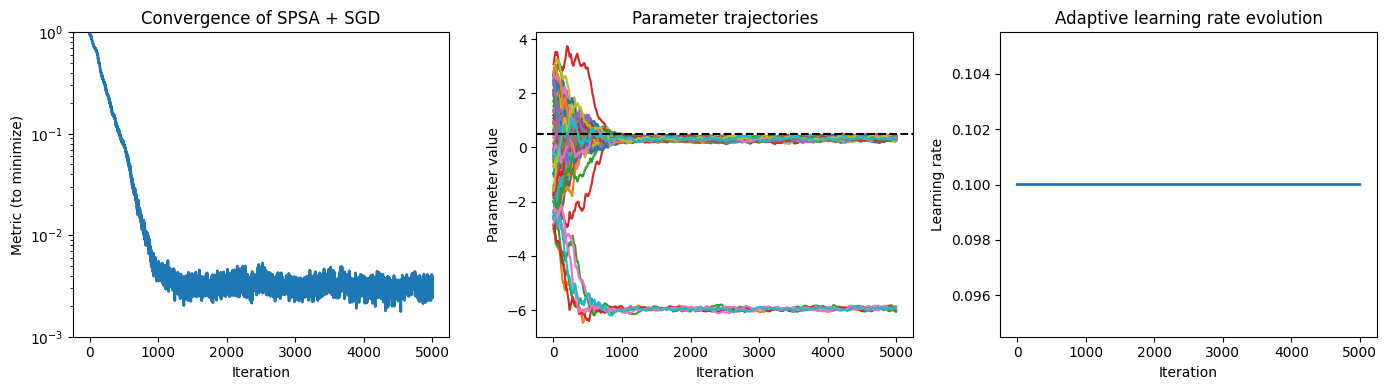

In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

from lion_pytorch import Lion


# --- setup ---
d = 100

base_lr = 1e-1
x = (torch.pi * (2 * torch.rand(d) - 1)).clone().detach().requires_grad_(True)  # leaf tensor

optimizer = optim.SGD([x], lr=base_lr, momentum=0.9)     # swap in RMSprop, Adadelta, etc.
# optimizer = optim.RMSprop([x], lr=base_lr, momentum=0.9)     # swap in RMSprop, Adadelta, etc.
# optimizer = Lion([x], lr=base_lr, weight_decay=1e-3)     # swap in RMSprop, Adadelta, etc.

def measure_fn(x_vec):
    """Simulated experiment: returns metric to minimize."""
    phi_noise = 2 * torch.pi / 100 * torch.randn(d)
    value = torch.abs(torch.sum(torch.exp(1j * (x_vec + phi_noise))))
    best_value = torch.abs(torch.sum(torch.exp(1j * torch.zeros(d))))
    return 1 - value / best_value # normalize to [0,1]

# --- logging ---
metrics = []
trajectories = []
lrs = []
prev_metric = None
m_perturbs = 1

# --- online loop ---
for k in range(5000):
    # SPSA perturbation
    c = 0.1
    
    # Averaging gradient estimate over m_perturbs
    ghat = torch.zeros_like(x)
    for _ in range(m_perturbs):
        Delta = torch.randint(0, 2, x.shape) * 2 - 1
        xp = x.detach() + c * Delta
        xm = x.detach() - c * Delta
        y_plus = measure_fn(xp)
        y_minus = measure_fn(xm)
        ghat += ((y_plus - y_minus) / (2 * c)) * Delta
    ghat /= m_perturbs

    # Apply optimizer update
    optimizer.zero_grad()
    x.grad = ghat.clone()
    # x = torch.angle(torch.exp(1j * (x - x.mean())))  # wrap angles to [-pi,+pi]
    optimizer.step()
    
    
    # 

    # --- enforce bounds [0,1] ---
    # with torch.no_grad():
    #     x.clamp_(-torch.pi, +torch.pi)

    # Track metric and trajectory
    metric_now = measure_fn(x.detach())
    metrics.append(metric_now.item())
    trajectories.append(x.detach().clone().numpy())

    # --- adaptive learning rate ---
    if prev_metric is not None:
        if metric_now < prev_metric:   # improved
            for g in optimizer.param_groups:
                g["lr"] *= 1.0      # increase LR by 5%
        else:                          # worse
            for g in optimizer.param_groups:
                g["lr"] *= 01.0       # decrease LR by 30%
    prev_metric = metric_now

    lrs.append(optimizer.param_groups[0]["lr"])

# --- convert logs ---
trajectories = torch.tensor(trajectories)  # shape (steps, d)

# --- plots ---
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

# Plot metric convergence
axs[0].plot(metrics, lw=2)
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Metric (to minimize)")
axs[0].set_title(f"Convergence of SPSA + {optimizer.__class__.__name__}")
axs[0].set_yscale("log")
axs[0].set_ylim(1e-3, 1)

# Plot first 3 parameters trajectories
axs[1].plot(trajectories, label="x[0]")
# axs[1].plot(trajectories[:, 1], label="x[1]")
# axs[1].plot(trajectories[:, 2], label="x[2]")
axs[1].axhline(0.5, color="k", ls="--", label="target")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Parameter value")
axs[1].set_title("Parameter trajectories")
# axs[1].legend()

axs[2].plot(lrs, lw=2)
axs[2].set_xlabel("Iteration")
axs[2].set_ylabel("Learning rate")
axs[2].set_title("Adaptive learning rate evolution")

plt.tight_layout()
plt.show()